In [ ]:
# pip install pandas sqlalchemy pymysql torch sklearn
# # or if you use Keras
# pip install keras tensorflow


In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Database credentials
db_user = 'root'
db_password = 'root'
db_host = '127.0.0.1'     # e.g., 'localhost'
db_port = '3306'          # default MySQL port
db_name = 'inven'

# Create a connection engine
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

# Fetch table names (schema)
table_names = pd.read_sql("SHOW TABLES;", engine)
print("Tables in the database:", table_names)

# Fetch data from your sales table
df = pd.read_sql("SELECT * FROM your_sales_table;", engine)
print(df.head())


In [ ]:
# Make sure date is datetime type
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('date')

# Set date as index
df.set_index('date', inplace=True)

# Normalize the sales values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['sales_amount'] = scaler.fit_transform(df[['sales_amount']])


In [ ]:
def data_stream(df, window_size=10):
    X, y = [], []
    sales_data = df['sales_amount'].values

    for i in range(len(sales_data) - window_size):
        X.append(sales_data[i:i+window_size])
        y.append(sales_data[i+window_size])

    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    for i in range(len(X)):
        yield X.iloc[i].values.reshape(-1, 1), y.iloc[i].values[0]


In [ ]:
import torch
import torch.nn as nn

class SalesLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [ ]:
# Initialize model, loss, optimizer
model = SalesLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

window_size = 10
stream = data_stream(df, window_size)

# Training Loop
for epoch in range(5):  # Increase epochs as needed
    for X_batch, y_batch in stream:
        X_batch = torch.tensor(X_batch, dtype=torch.float32).unsqueeze(0)  # (batch_size=1, seq_len, input_size)
        y_batch = torch.tensor([[y_batch]], dtype=torch.float32)

        # Forward pass
        output = model(X_batch)
        loss = criterion(output, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


In [ ]:
# Predict next step
last_window = df['sales_amount'].values[-window_size:]
last_window = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0).unsqueeze(2)

model.eval()
predicted_sales = model(last_window)
predicted_sales = scaler.inverse_transform(predicted_sales.detach().numpy())

print(f"Next predicted sales amount: {predicted_sales[0][0]:.2f}")


In [ ]:
# Load your old model
model.load_state_dict(torch.load('model.pth'))
model.train()

# Create data stream from only new data
new_stream = data_stream(new_df, window_size=5)

# Fine-tune for 2-3 epochs
for epoch in range(2):  
    for X_batch, y_batch in new_stream:
        # Normal training loop
        X_batch = torch.FloatTensor(X_batch).unsqueeze(0)  # [batch, seq, feature]
        y_batch = torch.FloatTensor([y_batch])

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()


# After joining tables

In [18]:
import pymysql
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
from datetime import datetime
from django.conf import settings

# Connect to MySQL
connection = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='root',
    database='inven'
)

# db_user = 'root'
# db_password = 'root'
# db_host = '127.0.0.1'     # e.g., 'localhost'
# db_port = '3306'          # default MySQL port
# db_name = 'inven'

In [19]:

# Step 1: Fetch and Join Data
query = """
SELECT 
    oi.id AS orderitem_id,
    o.order_date,
    p.product_name,
    p.unit_price,
    oi.quantity,
    oi.price_at_time_of_order
FROM members_orderitem oi
JOIN `members_order` o ON oi.order_id = o.id
JOIN `members_product` p ON oi.product_id = p.id
WHERE o.order_date IS NOT NULL
ORDER BY o.order_date ASC
"""

df = pd.read_sql(query, connection)
connection.close()

C:\Users\HP\AppData\Local\Temp\ipykernel_4196\3523267393.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   orderitem_id            18 non-null     int64         
 1   order_date              18 non-null     datetime64[ns]
 2   product_name            18 non-null     object        
 3   unit_price              18 non-null     float64       
 4   quantity                18 non-null     int64         
 5   price_at_time_of_order  18 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 996.0+ bytes


In [21]:
df.describe()

,orderitem_id,order_date,unit_price,quantity,price_at_time_of_order
count,18.000000,18,18.000000,18.000000,18.000000
mean,15.500000,2025-03-05 03:48:27.671546880,5597.794444,16.444444,5597.794444
min,7.000000,2025-01-13 16:12:04,30.000000,1.000000,30.000000
25%,11.250000,2025-01-22 00:37:14.500000,432.910000,1.500000,432.910000
50%,15.500000,2025-03-06 14:04:43,873.435000,7.500000,873.435000
75%,19.750000,2025-04-20 22:04:17.426683904,4000.000000,30.000000,4000.000000
max,24.000000,2025-04-25 09:29:02.906535,59091.540000,50.000000,59091.540000
std,5.338539,NaN,14080.956361,16.489648,14080.956361


In [22]:
# Step 2: Prepare Data
df['revenue'] = df['quantity'] * df['price_at_time_of_order']

# Only select needed columns
# df = df[['order_date', 'revenue']]

# Make sure order_date is datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Group by date and sum revenue
df_grouped = df.groupby(df['order_date'].dt.date)['revenue'].sum().reset_index()

# Rename columns (optional but clean)
df_grouped.columns = ['order_date', 'revenue']

# Normalize revenue
scaler = MinMaxScaler()
df_grouped['revenue'] = scaler.fit_transform(df_grouped[['revenue']])


In [24]:

# Step 3: Create Data Stream
def data_stream(df, window_size=5):
    data = df['revenue'].values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return list(zip(X, y))

stream = data_stream(df, window_size=5)


In [25]:

# Step 4: Define LSTM Model
class SalesLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 50)  # 1 layer, batch size, hidden size
        c0 = torch.zeros(1, x.size(0), 50)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # output from last time step
        return out

model = SalesLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [26]:

# Step 5: Training
for epoch in range(5):
    for X_batch, y_batch in stream:
        X_batch = torch.FloatTensor(X_batch).unsqueeze(0).unsqueeze(-1)  # [batch, seq, feature]
        y_batch = torch.FloatTensor([y_batch])

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed")


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [30]:

# Step 6: Save the model
# trained_model_dir = os.path.join(settings.MEDIA_ROOT, 'trained_models')

model_path = ('sales_forecast_model.pth')
torch.save(model.state_dict(), model_path)

print("Model training complete and saved!")


Model training complete and saved!


In [40]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Assuming you have this same scaler from training
from sklearn.preprocessing import MinMaxScaler

# --- Load the trained model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Load model
model = LSTMModel()
model.load_state_dict(torch.load('sales_forecast_model.pth'))
model.eval()

# --- Load your revenue data ---
# (Assuming you still have df or reload it)
# df = pd.read_csv('your_revenue_data.csv') # if needed

# (assuming df has 'revenue' and already normalized using scaler)
# If you don't have scaler from training, you need to re-fit it on your data

# --- Prepare input for prediction ---
window_size = 7  # same as your training

# Take last window_size points
last_window = df['revenue'].values[-window_size:]

# --- Define prediction function ---
def predict_future(model, last_window, days, scaler):
    predictions = []
    input_seq = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    for _ in range(days):
        with torch.no_grad():
            pred = model(input_seq)
            predictions.append(pred.item())

            # Slide window (corrected here)
            pred = pred.unsqueeze(2)  # Make it (batch_size, 1, features)
            input_seq = torch.cat((input_seq[:, 1:, :], pred), dim=1)

    # Inverse transform back to original revenue
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions

# --- Make predictions ---

# 1. Next day
next_day_preds = predict_future(model, last_window, 1, scaler)

# 1. Next week (7 days)
week_preds = predict_future(model, last_window, 7, scaler)

# 2. Next month (30 days)
month_preds = predict_future(model, last_window, 30, scaler)

# 3. Next year (365 days)
year_preds = predict_future(model, last_window, 365, scaler)

# --- Plotting ---


C:\Users\HP\AppData\Local\Temp\ipykernel_4196\3993472556.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sales_forecast_model.pth'))


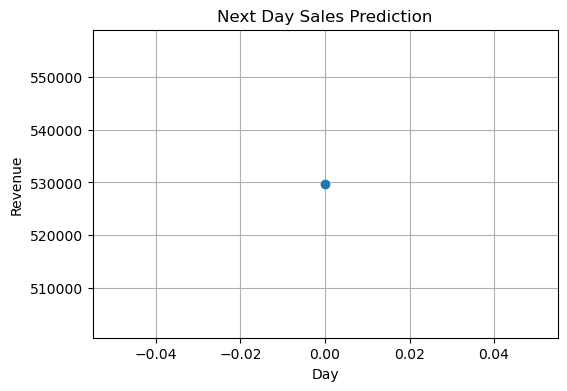

In [41]:

# --- Plotting ---
# 1. Next Day Prediction
plt.figure(figsize=(6, 4))
plt.plot(next_day_preds, marker='o')
plt.title('Next Day Sales Prediction')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

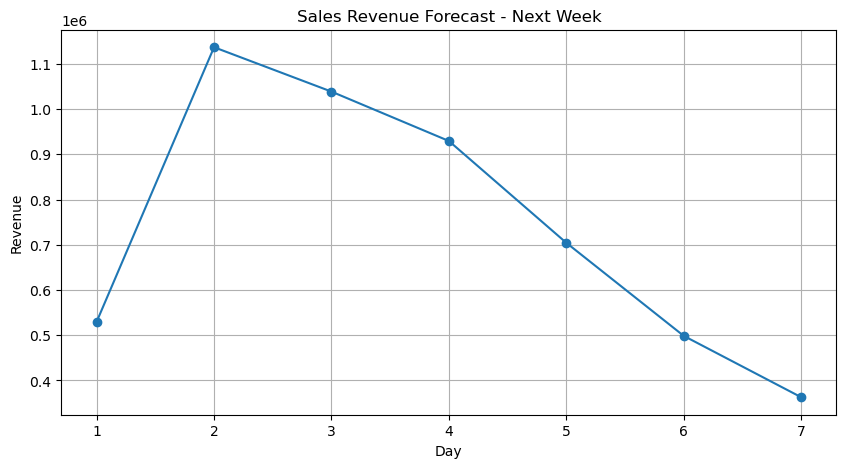

In [42]:

# Plot 1: Next Week
plt.figure(figsize=(10,5))
plt.plot(range(1, 8), week_preds, marker='o')
plt.title('Sales Revenue Forecast - Next Week')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


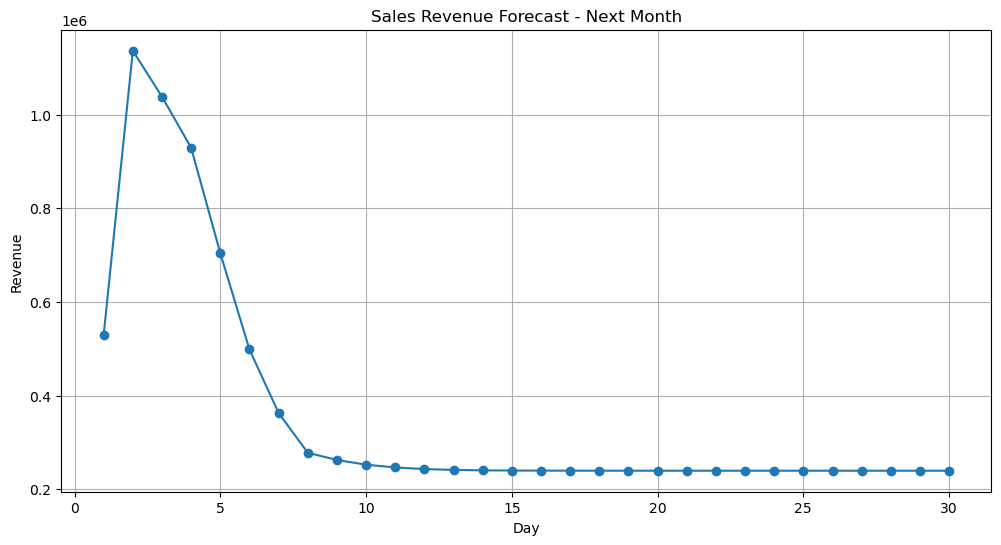

In [35]:

# Plot 2: Next Month
plt.figure(figsize=(12,6))
plt.plot(range(1, 31), month_preds, marker='o')
plt.title('Sales Revenue Forecast - Next Month')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


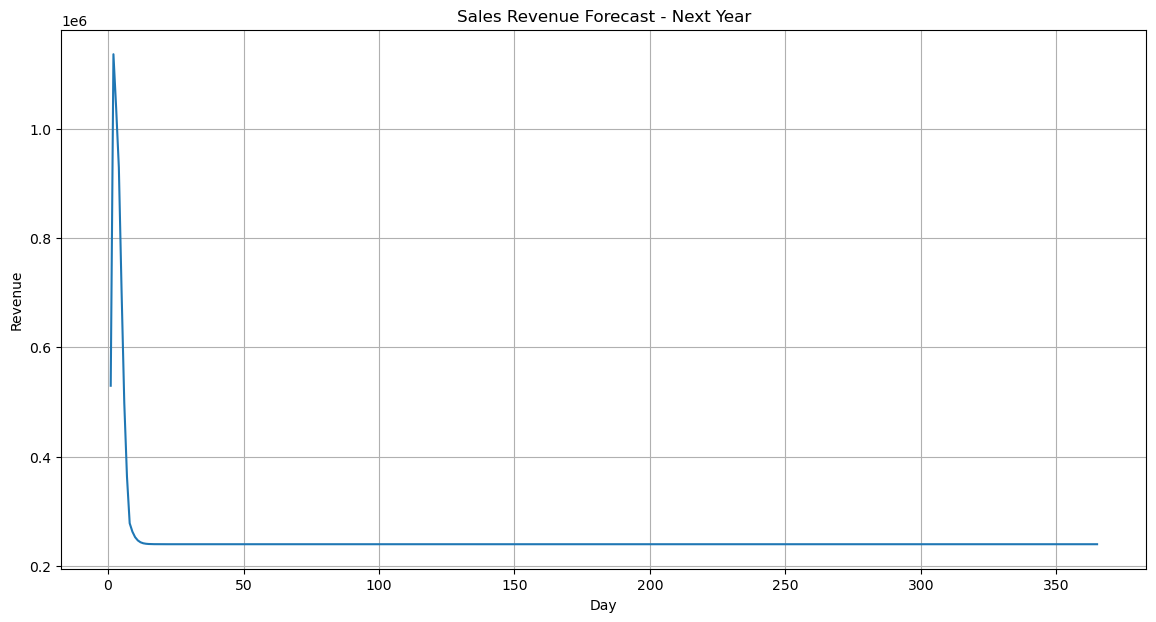

In [36]:

# Plot 3: Next Year
plt.figure(figsize=(14,7))
plt.plot(range(1, 366), year_preds)
plt.title('Sales Revenue Forecast - Next Year')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()
